In [106]:
# Clears all user-defined variables, functions, and imports without asking for confirmation.
%reset -f

In [107]:
# Imported Python files do not automatically reload after you modify them
# M1: Automatically Reload
%load_ext autoreload
%autoreload 2
# M2: Manual Reload
# import importlib
# import ksfdtw
# importlib.reload(ksfdtw)

# https://stackoverflow.com/questions/20309456/how-do-i-call-a-function-from-another-py-file
from ksfdtw import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# ---

---

# Time Series

In [108]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from pyts.metrics import dtw as pyts_dtw 
import warnings
warnings.simplefilter("ignore", FutureWarning) # pyts.metrics.dtw returns a FutureWarning
# from scipy.interpolate import interp1d
# from dtaidistance import dtw
# from scipy.stats import pearsonr

# 3 Preliminaries and Problem Statement

## 3.1 Euclidean Distance (ED)

Self-implemented ED

In [109]:
# Data from https://jmotif.github.io/sax-vsm_site/morea/algorithm/znorm.html
q = pd.Series(np.array([2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34]))
c = pd.Series(np.array([-0.12, -0.16, -0.13,  0.28,  0.37,  0.39,  0.18,  0.09,  0.15, -0.06,  0.06, -0.07, -0.13, -0.18, -0.26]))

In [110]:
ed(q, c), ed(q, c, True)

(np.float64(19.942780648645765), np.float64(397.7145))

In [111]:
# https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html
# https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.squared_distance.html
from sktime.distances import euclidean_distance as sktime_ed, squared_distance as sktime_ed_sq
sktime_ed(q.to_numpy(), c.to_numpy()), sktime_ed_sq(q.to_numpy(), c.to_numpy())


(19.942780648645765, 397.7145)

## 3.3 Uniform Scaling (US)

## Interpolation

In [112]:
# from scipy.ndimage import zoom
# def nearest_neighbor_interpolation(ts, new_length):
#     # order = 0 for nearest neighbor interpolation
#     return zoom(ts, new_length/len(ts), order=0)


In [113]:
# def nearest_neighbor_interpolation2(ts, new_length):
#     old_length = len(ts)
#     indices = np.ceil(np.linspace(1, old_length, new_length)).astype(int) - 1  # -1 for 0-based indexing
#     return np.array(ts)[indices]

In [114]:
ts = np.array([1,2,3,4,5,6])
nearest_neighbor_interpolation(ts, 8)

array([1, 2, 3, 3, 4, 5, 6, 6])

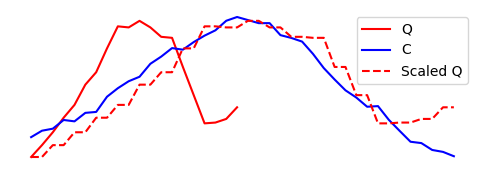

In [115]:
np.random.seed(0)
q = np.cumsum(np.random.rand(20) * 2 - 1 + np.sin(np.linspace(0, 2 * np.pi, 20)))
c = np.cumsum(np.random.rand(40) * 2 - 1 + np.sin(np.linspace(0, 2 * np.pi, 40)))
# c_x2 = np.linspace(0, 1, 10)
# c_y2 = np.piecewise(c_x2, [c_x2 < 0.5, c_x2 >= 0.5], [lambda x: 2*x, lambda x: 2*(1-x)])
# c_y2 = c_y2 *5
# offset = c[-1] - c_y2[0]
# c_y2 = c_y2 + offset
# c = np.concatenate([c, c_y2])
q_scaled = nearest_neighbor_interpolation(q, len(c))

q = normalize(q)
c = normalize(c)
q_scaled = normalize(q_scaled)

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(6, 2))

ax1.plot(q, label='Q', color='red')
ax1.plot(c, label='C', color='blue')
ax1.plot(q_scaled, label='Scaled Q', linestyle='--', color='red')

# ax1.set_title('Example of US')
ax1.legend()

# https://stackoverflow.com/questions/9295026/how-to-remove-axis-legends-and-white-padding
plt.axis('off')
# https://www.tutorialspoint.com/save-the-plots-into-a-pdf-in-matplotlib
plt.savefig("../figures/us.pdf", format="pdf", bbox_inches="tight")
plt.show()


Another example

In [116]:
c_x1 = np.linspace(0, 4 * np.pi, 100)
c_y1 = np.sin(c_x1) * 50 + 50  # Scale to range around 0~100
c_x2 = np.linspace(0, 1, 20)
c_y2 = np.piecewise(c_x2, [c_x2 < 0.5, c_x2 >= 0.5], [lambda x: 2*x, lambda x: 2*(1-x)])
c_y2 = c_y2 * 50  # Scale it similarly
offset = c_y1[-1] - c_y2[0]
c_y2 = c_y2 + offset
c = np.concatenate([c_y1, c_y2])
q_x = np.linspace(0, 4 * np.pi, 70)
q = np.sin(q_x) * 50 + 50  # Scale to range around 0~100
m = len(q)
n = len(c)
print(m, n)


70 120


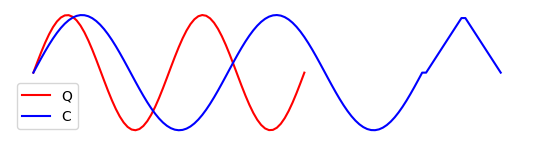

In [117]:
fig, ax1 = plt.subplots(figsize=(6, 2))
plt.plot(q, color='red', label='Q')
plt.plot(c, color='blue', label='C')
# plt.title('C vs. Q')
plt.xlabel('Time steps')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.axis('off')
plt.savefig("../figures/us-prefix.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [118]:
c_prefix = c[:100]
c_prefix_scaled = nearest_neighbor_interpolation(c_prefix, len(q))

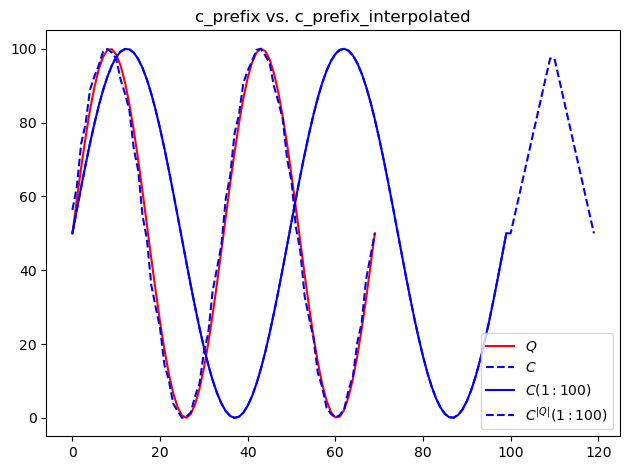

In [119]:
plt.plot(q, color='red', label='$Q$')
plt.plot(c, color='blue', linestyle='--', label='$C$')
plt.plot(c_prefix, color='blue', label='$C(1:100)$')
plt.plot(c_prefix_scaled, linestyle='--', color='blue', label='$C^{|Q|}(1:100)$')
plt.title('c_prefix vs. c_prefix_interpolated')
plt.legend()
plt.tight_layout()
plt.show()


Simply performing dtw on Q and C returns a bad result.

As shown in the above graph, Q and scaled C(1:100) have a good match.

In [120]:
ed(q, c_prefix_scaled)

np.float64(27.047409139811432)

In [121]:
l = 2 # scaling_factor 
best_so_far, best_k = us_usdtw(q, c, l, "ed")

In [122]:
best_so_far, best_k, best_k/m*100 # best_k/m*100 is the best scaling factor

(np.float64(20.03655846980296), 101, 144.28571428571428)

In [123]:
best_so_far, best_k, best_k/m*100 # best_k/m*100 is the best scaling factor

(np.float64(20.03655846980296), 101, 144.28571428571428)

## 3.5 Lower Bounds for Distance Measures

In [124]:
# Sample sequences
np.random.seed(18)
q = np.sin(np.linspace(0, 4 * np.pi, 100))
c = q + np.random.normal(0, 0.4, size=100)

In [125]:
np.sqrt(2**2)

np.float64(2.0)

In [208]:
def lb_shen_argmin_q(q, c, r, l=1):
    # print("Hello 4")
    # if isinstance(r, float):
    #     # Do something when r is a float
    #     print("r is a float.")
    #     # Add your float-specific logic here
    # elif isinstance(r, int):
    #     # Do something when r is an int
    #     print("r is an integer.")
    #     # Add your integer-specific logic here
    # else:
    #     raise ValueError("r must be either an integer or a float.")
    m = len(q)
    n = len(c)
    # print(m, n)
    dist = lambda a, b: (a - b)**2

    window_contrib = []
    dist_total = 0
    # window_contrib.append((0, 0))
    dist_total += dist(q[0], c[0]) 
    window_contrib.append(q[0]) # Window for c_o
    
    for j in range(1, min(np.ceil(l*m), n - 1)):
        start = int(max(0, np.ceil(j/l) - r))
        end = int(min(np.ceil(j*l) + r, m-1))
        # print(j, start, end)
        q_window = q[start:end+1]
        # print("q_window ", q_window)
        argmin = np.argmin([dist(c[j], q_k) for q_k in q_window]) #q_k = q_argmin
        min_dist = 0
        min_dist = dist(c[j], q_window[argmin])
        # print(min_dist)
        # min_dist = np.min([dist(c[j], q_k) for q_k in q_window])
        # window_contrib.append((j, q_window[argmin]))
        window_contrib.append(q_window[argmin])
        dist_total += min_dist
    dist_total += dist(q[-1], c[-1])
    window_contrib.append(q[-1]) 
    return np.sqrt(dist_total), window_contrib

In [171]:
dist, window_contrib = lb_shen_argmin_q(q,c, r=5)
dist

Hello 3


np.float64(2.2637676038911785)

100
Hello 3
2.2637676038911785
100


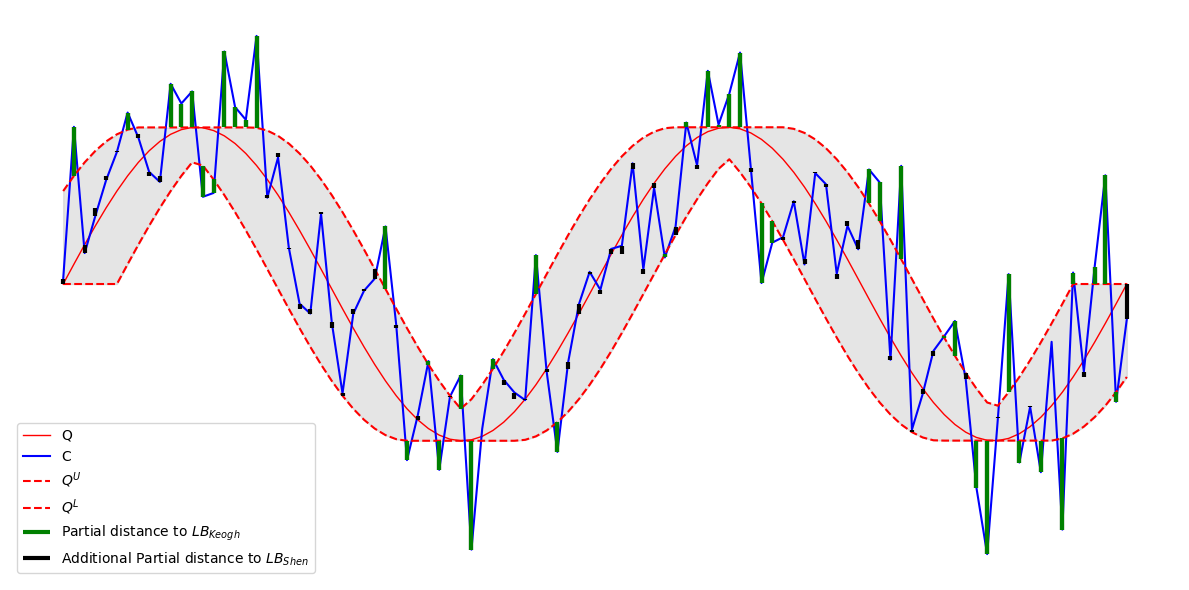

In [172]:
def plot_lb_keogh_full(q, c, radius):
    x = np.arange(len(q))
    lower, upper = lb_keogh_envelope(q, radius)
    lb = lb_keogh(q, c, radius)

    plt.figure(figsize=(12, 6))

    # Plot Q and C
    plt.plot(x, q, label='Q', color='red', linewidth=1)
    plt.plot(x, c, label='C', color='blue', linewidth=1.5)
    # Plot envelope
    plt.plot(x, upper, label='$Q^U$', linestyle='--', color='red', linewidth=1.5)
    plt.plot(x, lower, label='$Q^L$', linestyle='--', color='red', linewidth=1.5)
    plt.fill_between(x, lower, upper, color='gray', alpha=0.2)
    # Vertical bars
    # Old version
    # for i in x:
    #     if c[i] > upper[i]:
    #         plt.vlines(i, upper[i], c[i], color='black', linewidth=1.5)
    #     elif c[i] < lower[i]:
    #         plt.vlines(i, lower[i], c[i], color='black', linewidth=1.5)

    print(len(lower))
    lb_shen_dist, first_pair_smallest_elts_last_pair = lb_shen_argmin_q(q, c, r=5)
    print(lb_shen_dist)
    print(len(np.array(first_pair_smallest_elts_last_pair)))
    plt.vlines(np.arange(len(q)), c, first_pair_smallest_elts_last_pair,
           label='Additional Partial distance to $LB_{Shen}$', color='black', linewidth=3.0)
    # Elegant version
    plt.vlines(np.arange(len(q)), c, np.clip(c, lower, upper),
           label='Partial distance to $LB_{Keogh}$', color='green', linewidth=3.0)

    # plt.title(f"LB_Keogh Visualization\nLower Bound = {lb:.4f}")
    # plt.xlabel("Time Index")
    # plt.ylabel("Value")

    # Get all legend handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()

    # Swap the last two (assuming they are in the expected order)
    handles[-2], handles[-1] = handles[-1], handles[-2]
    labels[-2], labels[-1] = labels[-1], labels[-2]

    plt.legend(handles=handles, labels=labels, loc='lower left')
    # plt.legend(loc='upper right')
    # plt.grid(True)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("../figures/lb_keogh-lb_shen.pdf", format="pdf", bbox_inches="tight")
    plt.show()



plot_lb_keogh_full(q, c, radius=5)



In [165]:
pyts_dtw(q, c, method='sakoechiba', options={'window_size': 5})

3.6771353371031754

# 4 Piecewise Scaling & Dynamic Time Warping (PD)

# 5 Lower Bound of PD

# 6 Experimental Evaluation

# ---

In [ ]:
q = np.array([1,1,1,2,2,2])
c = np.array([1,1,1,1,2,2,2,2,5,6,7])

# tslearn

In [ ]:
from tslearn import metrics
ts1 = [1, 2, 3, 2, 1]
ts2 = [0, 0, 0, 0, 0]
env_low, env_up = metrics.lb_envelope(ts1, radius=1)

/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [ ]:
metrics.lb_keogh(ts_query=ts2, envelope_candidate=(env_low, env_up))

np.float64(2.8284271247461903)

# Testing

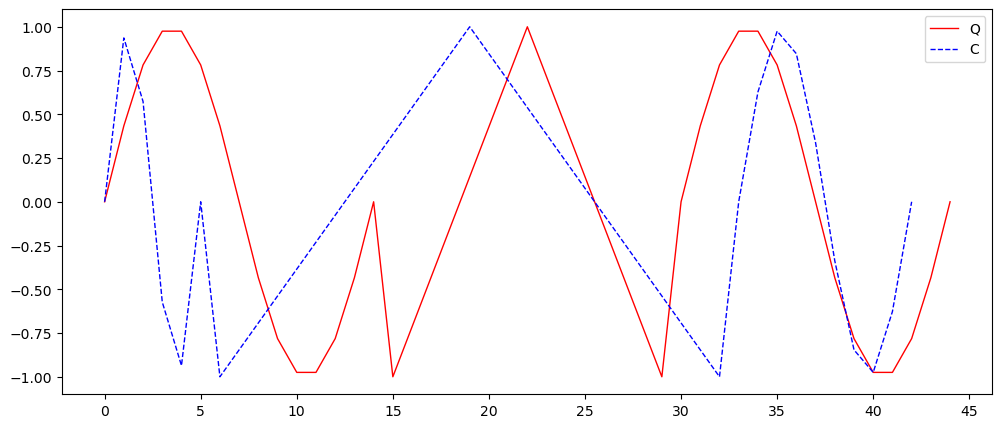

(45, 43)

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import sawtooth

# Step 1: Create segments
def generate_segments():
    s1 = np.sin(np.linspace(0, 2 * np.pi, 15)) 
    # s1 = np.linspace(0, 1, 15)
    s2 = sawtooth(np.linspace(0, 2 * np.pi, 15), 0.5)  # Triangle wave (periodic)
    # s2 = np.concatenate([np.ones(10), np.linspace(1, 0.5, 5)])
    s3 = np.tile([-1, 1], 10)
    tail = np.linspace(1, 0, 30)
    return s1, s2, s3, tail
    # return s1, s2, tail

# Step 3: Compose sequences
def create_series(with_tail=False):
    s1, s2, s3, tail = generate_segments()
    # s1, s2, tail = generate_segments()
    Q = np.concatenate([s1, s2, s1])
    # Q = np.concatenate([s1, s2])
    C = np.concatenate([
        linear_interpolation(s1, int(len(s1)*0.4)),
        linear_interpolation(s2, int(len(s2)*1.8)),
        linear_interpolation(s1, int(len(s1)*0.7))
    ])
    if with_tail:
        C = np.concatenate([C, tail])
    return Q, C

Q, C = create_series(False)

# Step 4: Plotting with ground truth segment boundaries
def plot_segmented_series(Q, C):
    plt.figure(figsize=(12, 5))
    plt.plot(Q, label="Q", color='red', linewidth=1)
    plt.plot(C, label="C", color='blue', linestyle='--', linewidth=1)

    # for idx in q_segments[1:-1]:  # skip 0 and end
    #     plt.axvline(idx, color='blue', linestyle='--', alpha=0.5)
    # for idx in c_segments[1:-1]:
    #     plt.axvline(idx, color='red', linestyle=':', alpha=0.5)

    # plt.title("Segmented Time Series with Expression Rate Difference + Tail")
    from matplotlib.ticker import MultipleLocator
    plt.gca().xaxis.set_major_locator(MultipleLocator(5))
    plt.legend()
    # plt.grid(True)
    # plt.xlabel("Time index")
    # plt.ylabel("Value")
    plt.show()

# # Step 5: Ground truth (simulated for this synthetic case)
# q_segments = [0, 30, 60, 90]  # Original segments in Q
# c_segments = [0,
#               len(scale_segment(np.linspace(0, 1, 30), 0.7)),
#               len(scale_segment(np.linspace(0, 1, 30), 0.7)) +
#               len(scale_segment(np.ones(30), 1.3)),
#               len(C)]  # including tail

plot_segmented_series(Q, C)
len(Q), len(C)


In [225]:
def psdtw_p(Q, C, l, P):
    print("Hello World 2")
    no_of_iteration = 0

    m, n = len(Q), len(C)
    s_Q, s_C = np.floor(m/P), np.floor(n/P) # Expected length of each subsequence piece 
    D = np.full((m, n, P), np.inf)
    # The indics of D are from 0 to m-1, n-1, and P-1.
    # D[2,:,:] refers to the first 3 elements of Q. The are inclusive.
    backtrack = np.full((m, n, P, 2), -1, dtype=int)  # The last dimension is used to store a pair of cutting points
    
    # Base case
    p = 1 
    for i_e in range(2, m+1): # e: ending, we need (m+1) to enumerate until m (inclusive)
        for j_e in range(2, n+1): # same as above
            m_p, n_p = i_e-0, j_e-0 # lengths of the two subsequence under comparison
            if (m_p > l*(n_p)) or (n_p > l*(m_p)): # scaling constraint
                continue
            if m_p < np.floor(s_Q/l) or n_p < np.floor(s_C/l): # min length of each subsequence constraint
                continue
            if m_p > np.floor(s_Q*l) or n_p > np.floor(s_C*l): # max length of each subsequence constraint
                continue
            dist = us_usdtw_p(Q[0:i_e], C[0:j_e], l, "dtw") # Sequences from 0 to i_e (j_e) (exclusive)
            #
            # dist, _ = lb_shen_argmin_q(Q[0:i_e], C[0:j_e], l)


            D[i_e-1, j_e-1, p-1] = dist # i_e-1 and j_e-1 as the indics for ending of Q, C in D are inclusive. 
            # p -1 as it counts from 0.
            backtrack[i_e-1, j_e-1, p-1] = [0, 0]
            no_of_iteration = no_of_iteration + 1
    # Recursive case
    for p in range(2, P+1):
        # Assigned length of previous subsequence constraint
        Q_occupied = 0
        C_occupied = 0
        Q_occupied = int(np.floor((s_Q/l)*(p-1)))
        C_occupied = int(np.floor((s_C/l)*(p-1)))
        for i_e in range(Q_occupied+2, m+1): # (Q_occupied+1) is the first available time stamps
            for j_e in range(C_occupied+2, n+1): # same as above
                best_so_far = np.inf
                best_indices = (-1, -1)
                # Iterate over all previous indices
                for i_s in range(Q_occupied, i_e+1):
                    for j_s in range(C_occupied, j_e+1):
                        m_p, n_p = i_e-i_s, j_e-j_s
                        if m_p < 2 or n_p < 2: # Their lengths should be at least 2. This constraint is also included in subsequence constraint
                            continue
                        if (m_p > l*(n_p)) or (n_p > l*(m_p)): # scaling constraint
                            continue    
                        if m_p < np.floor(s_Q/l) or n_p < np.floor(s_C/l): # min length of each subsequence constraint
                            continue
                        if m_p > np.floor(s_Q*l) or n_p > np.floor(s_C*l): # max length of each subsequence constraint
                            continue
                        dist = D[i_s-1, j_s-1, (p-1)-1] + us_usdtw_p(Q[i_s:i_e], C[j_s:j_e], l, "dtw")
                        # dist_cur, _ = lb_shen_argmin_q(Q[i_s:i_e], C[j_s:j_e], l)
                        # dist = D[i_s-1, j_s-1, (p-1)-1] + dist_cur

                        if dist < best_so_far:
                            best_so_far = dist
                            best_indices = (i_s, j_s)
                        no_of_iteration = no_of_iteration + 1
                D[i_e-1, j_e-1, p-1] = best_so_far
                backtrack[i_e-1, j_e-1, p-1] = best_indices
    print(f"Total iterations: {no_of_iteration}")
    return D, backtrack

In [178]:
def generate_backtrack_path(backtrack):
    P = backtrack.shape[2]
    path = []
    i, j = backtrack[-1,-1,-1] # Current State
    path.append((i, j))
    P = P-1
    while P > 0:
        i, j = backtrack[i-1, j-1, P-1]
        path.append((i, j))
        P = P-1
    # https://stackoverflow.com/questions/509211/how-slicing-in-python-works
    return path[::-1]

In [180]:
dist, _ = lb_shen_argmin_q(Q[:15], C[:15], 5)
dist

Hello 3


np.float64(0.4433789714213157)

In [181]:
hello_wolrd()

Hello World


In [226]:
%%time
D, backtrack = psdtw_p(Q, C, 2, 3)

Hello World 2
Total iterations: 224988
CPU times: user 27.8 s, sys: 733 ms, total: 28.5 s
Wall time: 28.3 s


In [227]:
D

array([[[       inf,        inf,        inf],
        [       inf,        inf,        inf],
        [       inf,        inf,        inf],
        ...,
        [       inf,        inf,        inf],
        [       inf,        inf,        inf],
        [       inf,        inf,        inf]],

       [[       inf,        inf,        inf],
        [       inf,        inf,        inf],
        [       inf,        inf,        inf],
        ...,
        [       inf,        inf,        inf],
        [       inf,        inf,        inf],
        [       inf,        inf,        inf]],

       [[       inf,        inf,        inf],
        [       inf,        inf,        inf],
        [       inf,        inf,        inf],
        ...,
        [       inf,        inf,        inf],
        [       inf,        inf,        inf],
        [       inf,        inf,        inf]],

       ...,

       [[       inf,        inf,        inf],
        [       inf,        inf,        inf],
        [       inf,  

In [228]:
backtrack[-1,-1,-1]

array([32, 35])

In [229]:
len(Q), len(C)

(45, 43)

In [ ]:
# Indics in D and backtrack are inclusive. For example, 49 means time series from 0 to 49 (inclusive)

In [214]:
generate_backtrack_path(backtrack)

[(np.int64(0), np.int64(0)),
 (np.int64(12), np.int64(7)),
 (np.int64(26), np.int64(27))]

In [232]:
D[-1, -1, -1]

np.float64(1.649901045302047)

In [ ]:
D[23,:,0]

array([       inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf, 1.67583694, 1.6878518 , 1.39458142, 1.62733245,
       1.4022449 , 1.42691035, 1.42053648, 1.24836991, 1.47646924,
       1.76335371, 1.46962808, 1.64228918, 2.27648782, 2.32726986,
       2.72343495, 3.28677608, 3.82554358,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf])

In [ ]:
# testing checkout 2

---

We are going to introduce some common time series libraries.
- [tslean](https://tslearn.readthedocs.io/en/stable/)
- [sktime](https://www.sktime.net/en/stable/)
- [pyts](https://pyts.readthedocs.io/en/stable/)
- [aeon](https://www.aeon-toolkit.org/en/stable/)
- [dtaidistance](https://dtaidistance.readthedocs.io/en/latest/)

And some time series database.
- [Time Series Classification Website](https://www.timeseriesclassification.com/index.php)

# Experiments

About the dataset
- Class 1 is "gun" and class 2 is "no gun (pointing)"
- References
    - https://www.timeseriesclassification.com/description.php?Dataset=GunPoint
    - https://www.timeseriesclassification.com/description.php?Dataset=GunPointOldVersusYoung
    - https://rdrr.io/cran/LPStimeSeries/man/GunPoint.html
    - Related papers
        - https://www.cs.ucr.edu/~eamonn/DTW_myths.pdf
        - https://arxiv.org/pdf/1810.07758

Best match index: 0, Label: 1
Distance: 0.0000


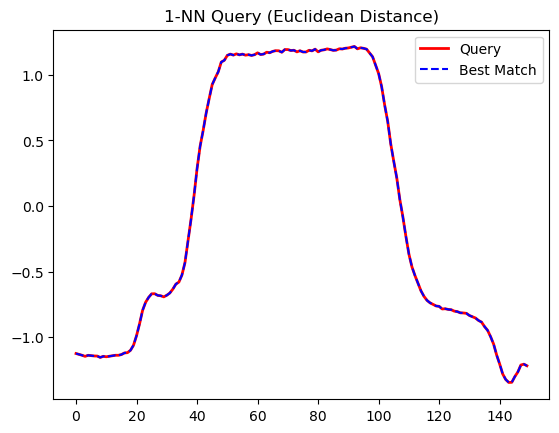

In [235]:
# Import dataset
import numpy as np
from tslearn.datasets import UCR_UEA_datasets
import matplotlib.pyplot as plt

# Load dataset
ucr = UCR_UEA_datasets()
X_train, y_train, X_test, y_test = ucr.load_dataset("GunPoint")
X_train = X_train.squeeze()

# Squeeze to 2D (n_samples, time_length)(univariate)
X_train = X_train.squeeze()
X_test = X_test.squeeze()

query_ts = X_test[0]

# Compute Euclidean distances to all training samples
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

distances = np.array([euclidean_distance(query_ts, x) for x in X_test])

# Find best match
best_idx = np.argmin(distances)
best_match = X_test[best_idx]

print(f"Best match index: {best_idx}, Label: {y_test[best_idx]}")
print(f"Distance: {distances[best_idx]:.4f}")

# Plot
plt.plot(query_ts, label="Query", linewidth=2, color="red")
plt.plot(best_match, label="Best Match", linestyle="--", color="blue")
plt.legend()
plt.title("1-NN Query (Euclidean Distance)")
plt.show()



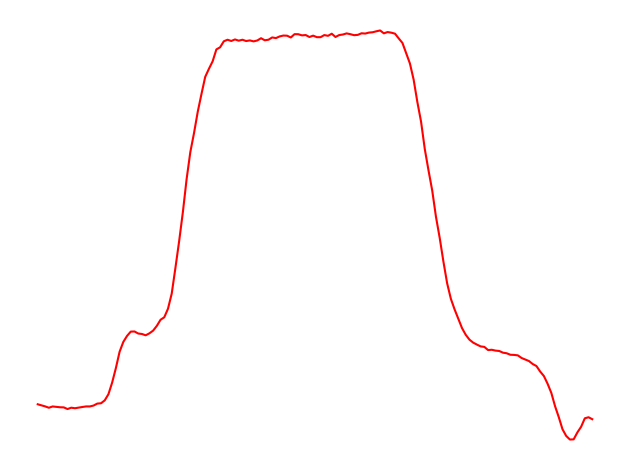

In [236]:
# gun
plt.plot(X_test[y_test == 1][0], color="red")
plt.axis('off')
plt.tight_layout()
plt.show()

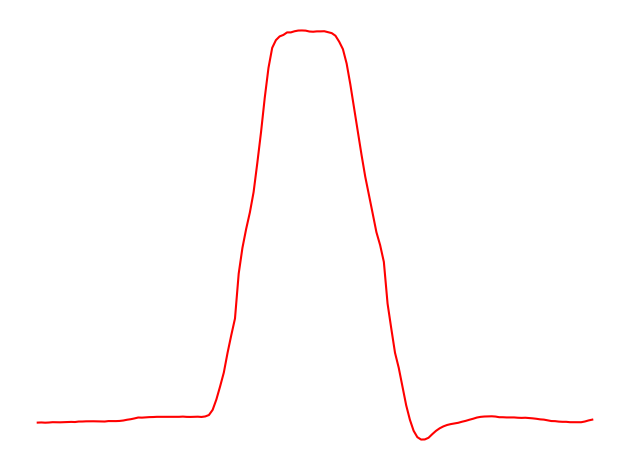

In [237]:
# pointing
plt.plot(X_test[y_test == 2][0], color="red")
plt.axis('off')
plt.tight_layout()
plt.show()

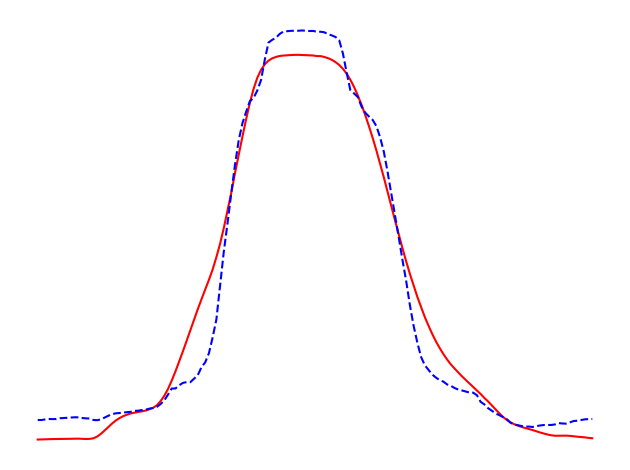

In [238]:
# gun
# import numpy as np
# import matplotlib.pyplot as plt

# Compute the mean time series
prototype_mean = np.mean(X_test[y_test == 1], axis=0)
# Compute the median time series
median_prototype = np.median(X_test[y_test == 1], axis=0)

# Plot the mean prototype
plt.plot(prototype_mean, label="Mean Prototype", color="red")
# Plot the median prototype
plt.plot(median_prototype, label="Median Prototype", color="blue", linestyle="--")
# plt.title("Idealized Prototype")
plt.xlabel("Time Step")
plt.ylabel("Value")
# plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

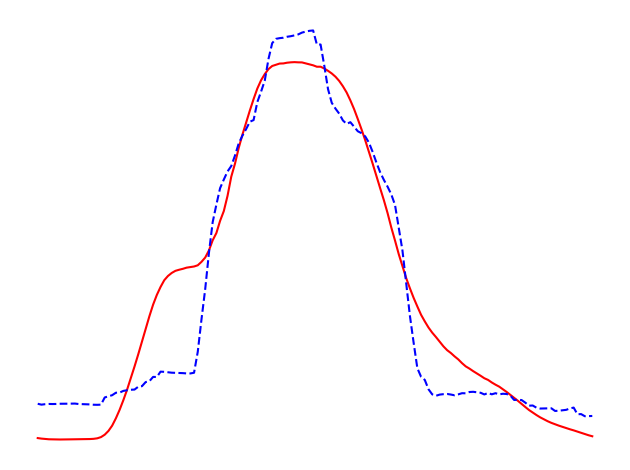

In [239]:
# pointing
# Compute the mean time series
prototype_mean = np.mean(X_test[y_test == 2], axis=0)
# Compute the median time series
median_prototype = np.median(X_test[y_test == 2], axis=0)

# Plot the mean prototype
plt.plot(prototype_mean, label="Mean Prototype", color="red")
# Plot the median prototype
plt.plot(median_prototype, label="Median Prototype", color="blue", linestyle="--")
# plt.title("Idealized Prototype")
plt.xlabel("Time Step")
plt.ylabel("Value")
# plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

In [240]:
Q = X_test[y_test == 1][0]

In [241]:
P = 3
m = len(Q)
m_p = np.floor(m/3).astype(int)

P,m,m_p


(3, 150, np.int64(50))

In [ ]:
# # Create P subsequences
# subsequences = [Q[i*m_p:(i+1)*m_p] for i in range(P)]

# # Print the subsequences to verify
# for idx, subseq in enumerate(subsequences):
#     print(f"Subsequence {idx+1}: {subseq}")
# len(subsequences)

In [242]:
Q_test= np.append(Q, [4, 18])

In [243]:
# Example time series data (Q) and number of subsequences (P)
Q = X_test[y_test == 1][0]
P = 3

m = len(Q)
subseq_length = np.floor(m / P).astype(int)  # Length of each subsequence
remainder = m % P  # Remainder to distribute, how many subsequences should have one extra value

# Create P subsequences
subsequences = []
start_idx = 0

for i in range(P):
    # Determine the end index for the current subsequence
    end_idx = start_idx + subseq_length + (1 if i < remainder else 0) # For each subsequence, we add one extra element if the subsequence index is less than the remainder.
    subsequences.append(Q[start_idx:end_idx])
    start_idx = end_idx  # Update start index for next subsequence

# Print the subsequences to verify
for idx, subseq in enumerate(subsequences):
    print(f"Subsequence {idx+1}: {subseq}")
    print(len(subseq))

Subsequence 1: [-1.1250133  -1.1313383  -1.1382884  -1.1466873  -1.1386387  -1.1414312
 -1.1436908  -1.1443789  -1.1549123  -1.1464212  -1.1497246  -1.1457227
 -1.1419403  -1.1384288  -1.1385201  -1.1329855  -1.1206946  -1.1185964
 -1.1005789  -1.0618869  -0.98877018 -0.89804927 -0.79586606 -0.73432104
 -0.69687043 -0.66992052 -0.66910759 -0.68194036 -0.68481332 -0.69305372
 -0.68082429 -0.66386028 -0.63402064 -0.5958185  -0.58019191 -0.52662465
 -0.43224316 -0.27027162 -0.10318644  0.07854224  0.28436347  0.45409849
  0.57409933  0.70714616  0.8182297   0.92508286  0.97561574  1.0226481
  1.0969569   1.1102969 ]
50
Subsequence 2: [1.1479976 1.1575769 1.1498129 1.1594703 1.1517029 1.157521  1.1494632
 1.153298  1.1473326 1.1530236 1.1671015 1.1542641 1.1576391 1.1720068
 1.1678774 1.1783764 1.1837646 1.1829012 1.1717443 1.192459  1.1921674
 1.184896  1.1869894 1.1746437 1.183216  1.1736466 1.1736466 1.1868374
 1.1821363 1.1953776 1.174863  1.1868828 1.1903198 1.1972967 1.1923345
 1.186

In [244]:
import random
l = 2
random.seed(20) 
for idx, subseq in enumerate(subsequences):
    new_length = random.randint(np.ceil(m_p/l).astype(int), np.ceil(m_p*l).astype(int))
    subsequences[idx] =nearest_neighbor_interpolation(subsequences[idx],new_length)
    print(f"Subsequence {idx+1}: {subseq}")
    print(len(subsequences[idx]))

    

Subsequence 1: [-1.1250133  -1.1313383  -1.1382884  -1.1466873  -1.1386387  -1.1414312
 -1.1436908  -1.1443789  -1.1549123  -1.1464212  -1.1497246  -1.1457227
 -1.1419403  -1.1384288  -1.1385201  -1.1329855  -1.1206946  -1.1185964
 -1.1005789  -1.0618869  -0.98877018 -0.89804927 -0.79586606 -0.73432104
 -0.69687043 -0.66992052 -0.66910759 -0.68194036 -0.68481332 -0.69305372
 -0.68082429 -0.66386028 -0.63402064 -0.5958185  -0.58019191 -0.52662465
 -0.43224316 -0.27027162 -0.10318644  0.07854224  0.28436347  0.45409849
  0.57409933  0.70714616  0.8182297   0.92508286  0.97561574  1.0226481
  1.0969569   1.1102969 ]
44
Subsequence 2: [1.1479976 1.1575769 1.1498129 1.1594703 1.1517029 1.157521  1.1494632
 1.153298  1.1473326 1.1530236 1.1671015 1.1542641 1.1576391 1.1720068
 1.1678774 1.1783764 1.1837646 1.1829012 1.1717443 1.192459  1.1921674
 1.184896  1.1869894 1.1746437 1.183216  1.1736466 1.1736466 1.1868374
 1.1821363 1.1953776 1.174863  1.1868828 1.1903198 1.1972967 1.1923345
 1.186

In [246]:
Q_scaled = np.concatenate(subsequences)

In [247]:
len(Q_scaled)

139

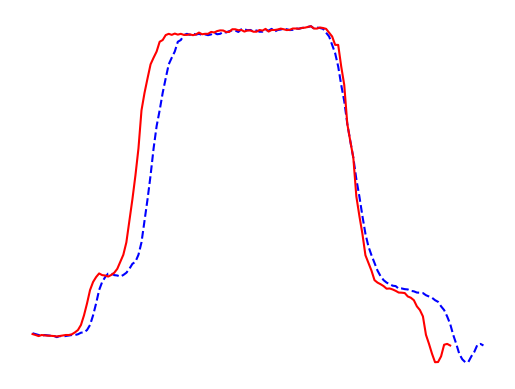

In [248]:
plt.plot(Q, color="blue", linestyle='--')
plt.plot(Q_scaled, color="red")
plt.axis('off')
plt.show()

In [255]:
pyts_dtw(Q_scaled[0:44], X_test[0][:50], method='sakoechiba', options={'window_size': 1})

0.12287026644464721

In [250]:
us_usdtw_p(Q_scaled[0:44], X_test[0][:50], 2, "dtw")

0.1213903929501367

In [251]:
pyts_dtw(Q_scaled[44:44+58], X_test[0][50:50+50], method='sakoechiba', options={'window_size': 0.1})

0.0

In [252]:
pyts_dtw(Q_scaled[44+58:44+58+37], X_test[0][100:150], method='sakoechiba', options={'window_size': 0.1})

0.23113461673508068

In [253]:
pyts_dtw(Q_scaled, X_test[0], method='sakoechiba', options={'window_size': 0.1})

0.24915688474505548

In [254]:
D, backtrack = psdtw_p(Q_scaled, X_test[0], 3, 3)

Hello World 2


KeyboardInterrupt: 

In [ ]:
# distances = np.array([pyts_dtw(Q_scaled, x, method='sakoechiba', options={'window_size': 5}) for x in X_test])
distances = np.array([psdtw_p(Q_scaled, x, 3, 3) for x in X_test])


# Find best match
best_idx = np.argmin(distances)
best_match = X_test[best_idx]

print(f"Best match index: {best_idx}, Label: {y_test[best_idx]}")
print(f"Distance: {distances[best_idx]:.4f}")

# Plot
plt.plot(Q, label="Query", linewidth=2, color="red")
plt.plot(Q_scaled, label="Query", linewidth=2, linestyle="--", color="red")
plt.plot(best_match, label="Best Match", linestyle="--", color="blue")
plt.legend()
plt.title("1-NN Query (Euclidean Distance)")
plt.show()

KeyboardInterrupt: 

In [ ]:
distances = np.array([pyts_dtw(Q_scaled, x, method='sakoechiba', options={'window_size': 0.1}) for x in X_test])

In [ ]:
distances

array([ 0.27698946,  6.89411423, 13.09993025,  1.67630925,  5.52196123,
        6.8679878 ,  3.99919174,  4.77056443,  4.86187199,  6.31403893,
        5.75828711,  5.39998386,  7.49044409,  1.35381394,  1.06786541,
        5.26539645,  6.53214954,  7.73101486,  6.82101245,  6.38043529,
        2.20154862,  5.54187905,  5.72075959,  5.9196238 ,  2.43993664,
        3.29987924,  1.04404133,  0.99481222,  5.40145583,  5.12451123,
        6.3010599 ,  5.40300293,  2.60060477,  6.44245837,  5.79817032,
        4.51663564,  5.4070002 ,  5.0421163 ,  2.31376234,  5.59043735,
        5.62354105,  8.41897015,  5.11401342,  5.35303154,  6.84320362,
        3.59035933,  4.00403821,  5.38148332,  7.00199881,  5.36785569,
        6.81499247,  4.2771049 ,  5.21873089,  9.03194108,  5.74706238,
        1.91565723,  2.75896234,  6.48840087,  5.44476991,  6.9022761 ,
        0.48957449, 12.58992715,  1.15093005,  5.14981825,  5.90025374,
        5.01309823,  1.40269066,  5.80317925,  6.60137181,  6.43

In [ ]:
sorted_indices = np.argsort(distances)
second_min = distances[sorted_indices[1]]
print("Second smallest:", second_min)

Second smallest: 0.3770646371922702


In [ ]:
sorted_indices[1]

np.int64(102)

In [ ]:
sorted_indices

array([  0, 102, 112,  60, 138, 136,  86,  98,  27,  26,  14,  62,  13,
        66, 101, 132,   3, 117, 115,  55, 120,  20,  38,  24,  91,  32,
        56, 126,  25,  45,   6,  46, 124,  78,  51, 121,  35, 119,   7,
       116, 127, 105,   8, 139,  65,  37, 103, 146,  42,  29, 114,  63,
       130,  52,  92,  15, 106, 149,  43,  99,  49,  47,  72,  11,  28,
        31,  36,  58,   4,  21,  87,  39, 118,  40,  79,  81,  80, 137,
        22,  54,  10,  34, 147,  67, 148,  89,  64,  23, 133, 131,  73,
        88, 110, 142, 108,  70,  95,  71,  30,   9,  19,  96, 144,  76,
        69,  74,  33,  90,  57, 125,  16, 122,  85,  97,  68,  75, 134,
       128,  50,  18,  44,   5,   1,  59, 111, 113,  48, 145,  83, 104,
        94,  93, 109,  84,  12,  17, 100, 140,  41,  53, 107, 135, 141,
        77, 123, 129,  82, 143,  61,   2])

In [ ]:
sorted_indices

array([  0, 102, 112,  60, 138, 136,  86,  98,  27,  26,  14,  62,  13,
        66, 101, 132,   3, 117, 115,  55, 120,  20,  38,  24,  91,  32,
        56, 126,  25,  45,   6,  46, 124,  78,  51, 121,  35, 119,   7,
       116, 127, 105,   8, 139,  65,  37, 103, 146,  42,  29, 114,  63,
       130,  52,  92,  15, 106, 149,  43,  99,  49,  47,  72,  11,  28,
        31,  36,  58,   4,  21,  87,  39, 118,  40,  79,  81,  80, 137,
        22,  54,  10,  34, 147,  67, 148,  89,  64,  23, 133, 131,  73,
        88, 110, 142, 108,  70,  95,  71,  30,   9,  19,  96, 144,  76,
        69,  74,  33,  90,  57, 125,  16, 122,  85,  97,  68,  75, 134,
       128,  50,  18,  44,   5,   1,  59, 111, 113,  48, 145,  83, 104,
        94,  93, 109,  84,  12,  17, 100, 140,  41,  53, 107, 135, 141,
        77, 123, 129,  82, 143,  61,   2])

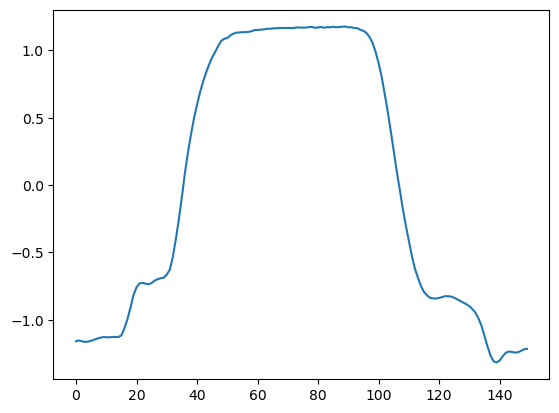

In [ ]:
plt.plot(X_test[sorted_indices[2]])